# Hiragana Handwritten Character Classification
## CS-UY 4563: Introduction to Machine Learning
### Samuel Jimenez Canizal
**Dataset:** Handwritten Japanese Hiragana Characters  
**Models:** Logistic Regression, K-Nearest Neighbors, Neural Network  

## IMPORTS
This section imports all necessary libraries. All the dependencies are listed in 'requirements.txt' and are installed inside a virtual environment.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import hog
from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from constants import HIRAGANA_MAP, PHONETIC_LABELS

In [2]:
data_root = Path("data/handwritten-hiragana")

## Feature Extraction

In this section I convert each image into a numeric feature vector. The dataset provides 100 images of each basic character in Hiragana that I will manually engineer into numeric features. Such features include:

- Pixel intensity statistics
- Ink density and bounding box geometry  
- Center of mass  
- Laplacian variance (sharpness)  
- Histogram of Oriented Gradients (HOG) features

This process will produce a 22-feature vector.

In [6]:
def extract_features_from_image(path, target_size = (28, 28)):
    character_image = imread(path)
    if character_image.ndim == 3:
        character_image = rgb2gray(character_image)

    character_image = resize(character_image, target_size, anti_aliasing = True).astype(np.float32)

    mean_val = character_image.mean()
    std_val = character_image.std()
    min_val = character_image.min()
    # max_val = character_image.max()

    thresh = character_image.mean()
    ink = character_image < thresh
    ink_count = ink.sum()

    coords = np.argwhere(ink)
    if coords.size > 0:
        (y_min, x_min), (y_max, x_max) = coords.min(0), coords.max(0)
        bbox_height = y_max - y_min + 1
        bbox_width  = x_max - x_min + 1
        bbox_area   = bbox_height * bbox_width
        aspect_ratio = bbox_width / bbox_height if bbox_height > 0 else 0.0
    else:
        bbox_height = bbox_width = bbox_area = aspect_ratio = 0.0

    com_y, com_x = ndimage.center_of_mass(character_image)

    lap = ndimage.laplace(character_image)
    lap_var = lap.var()

    # hog_vec = hog(character_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
    # hog_short = hog_vec[:10]

    features = np.array([
        mean_val, 
        std_val, 
        min_val, 
        # max_val, 
        ink_count, 
        bbox_height, 
        bbox_width, 
        bbox_area, 
        aspect_ratio,
        com_x, 
        com_y,
        lap_var,
        # *hog_short
    ], dtype=np.float32)

    return features

In [4]:
image_paths = list(data_root.rglob("*.jpg"))

In [7]:
PHONETIC_TO_ID = {phonetic: i for i, phonetic in enumerate(PHONETIC_LABELS)}

X_list = []
y_list = []

for img_path in tqdm(image_paths):
    class_name = img_path.parent.name

    label_id = PHONETIC_TO_ID[class_name]
    features = extract_features_from_image(img_path)

    X_list.append(features)
    y_list.append(label_id)

X = np.vstack(X_list)
y = np.array(y_list)

X.shape, y.shape

100%|██████████| 4600/4600 [00:32<00:00, 142.85it/s]


((4600, 11), (4600,))

In [8]:
def decode_label(prediction):
  phonetic = PHONETIC_LABELS[prediction]
  return HIRAGANA_MAP.get(phonetic)

## Exploratory Analysis

Before splitting the dataset and training the chosen models, here is some exploratory analysis. The goals of this exploratory analysis is to visualize feature distribution, examine the relationship between features and the target class, inspect the correlation between each feature, and to understand why some features are important to classify characters. Visual representations that will be used to accomplish this include:
- Correlation Matrix
- Density Plots
- Feature vs Target Distribution
- Feature Distribution per Character
- Visuals of Handwritten Characters

In [9]:
feature_columns = [
    "mean_val", "std_val", "min_val", "ink_count", "bbox_height", "bbox_width", "bbox_area", "aspect_ratio", "com_x", "com_y", "lap_var"
]

df = pd.DataFrame(X, columns = feature_columns)
df["label"] = y

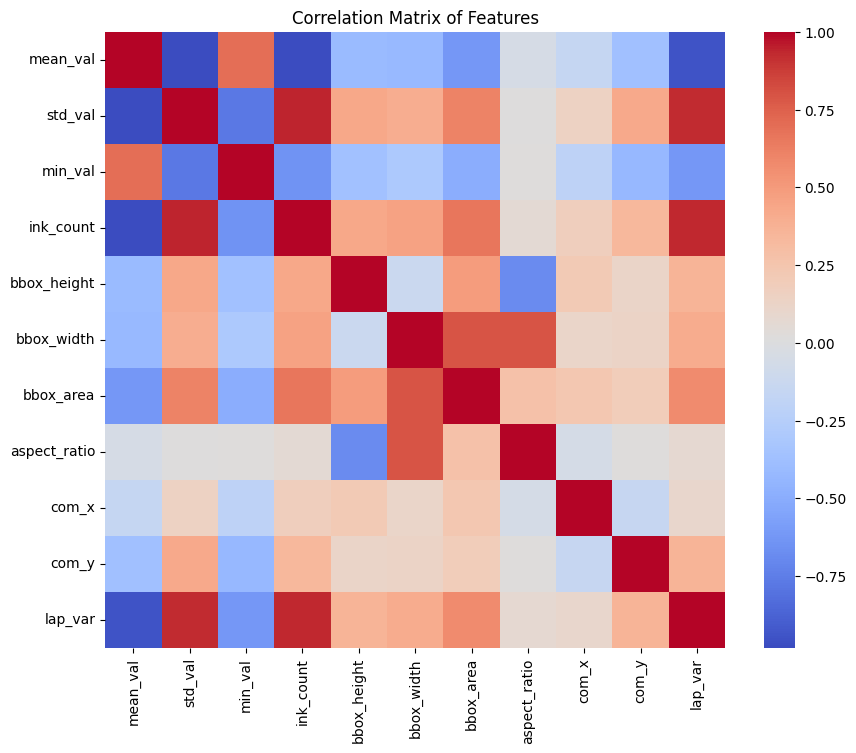

In [10]:
corr = df.drop(columns = ["label"]).corr()

plt.figure(figsize = (10, 8))
sns.heatmap(corr, cmap = "coolwarm", annot = False)
plt.title("Correlation Matrix of Features", fontsize = 12)
plt.show()

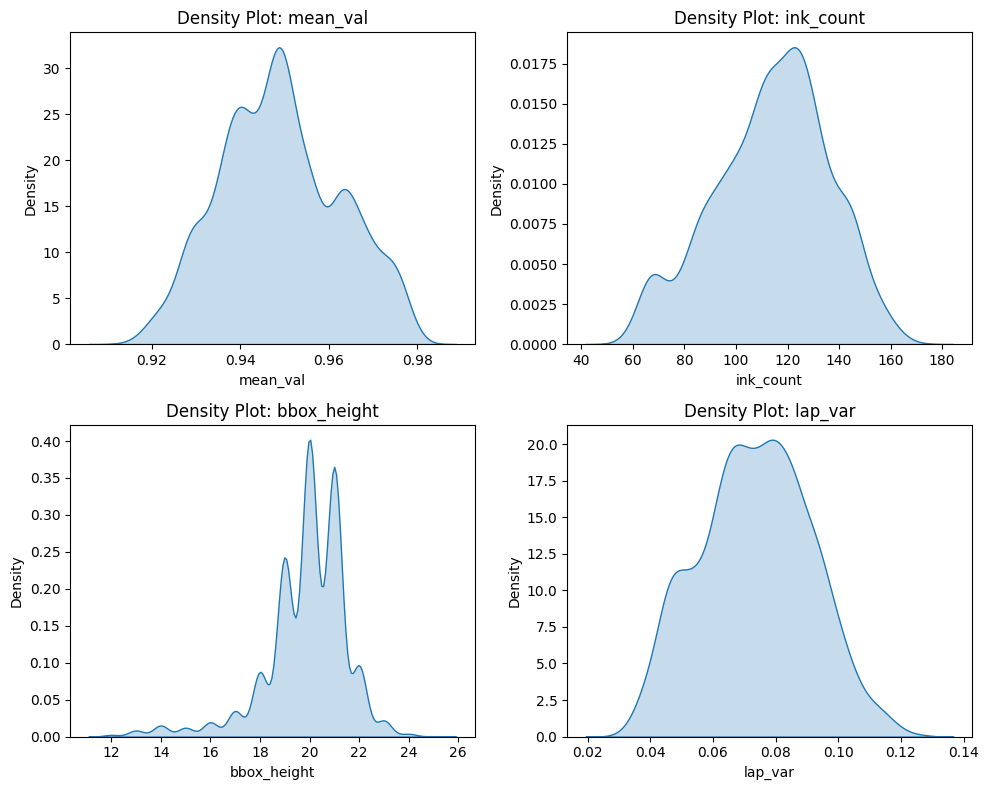

In [11]:
sample_features = ["mean_val", "ink_count", "bbox_height", "lap_var"]

plt.figure(figsize = (10, 8))
for i, ft in enumerate(sample_features):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(df[ft], fill = True)
    plt.title(f"Density Plot: {ft}")

plt.tight_layout()
plt.show()

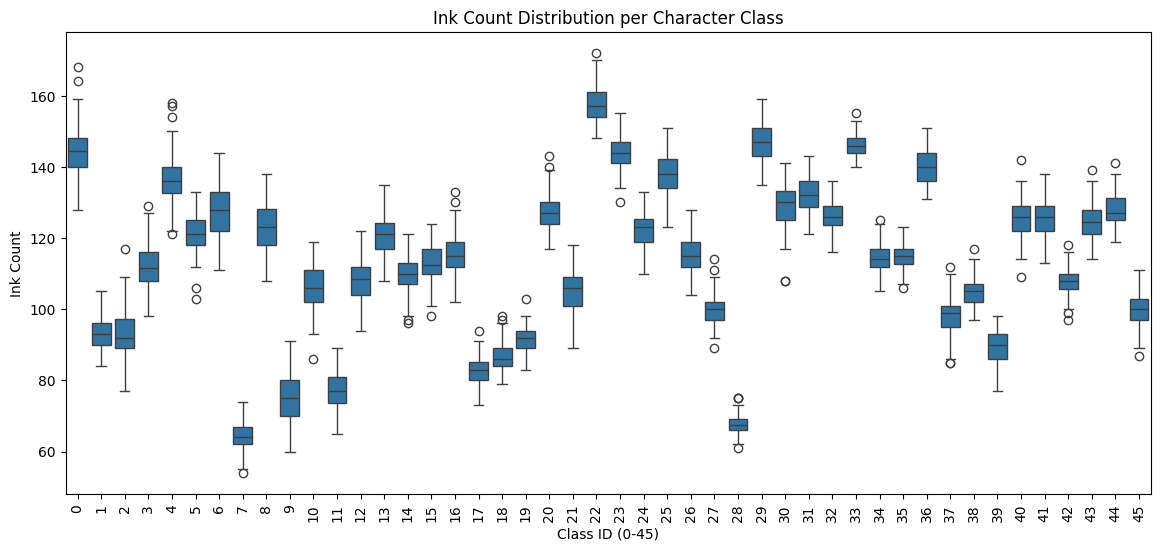

In [12]:
plt.figure(figsize = (14, 6))
sns.boxplot(data = df, x = "label", y = "ink_count")
plt.title("Ink Count Distribution per Character Class", fontsize = 12)
plt.xlabel("Class ID (0-45)")
plt.ylabel("Ink Count")
plt.xticks(rotation = 90)
plt.show()

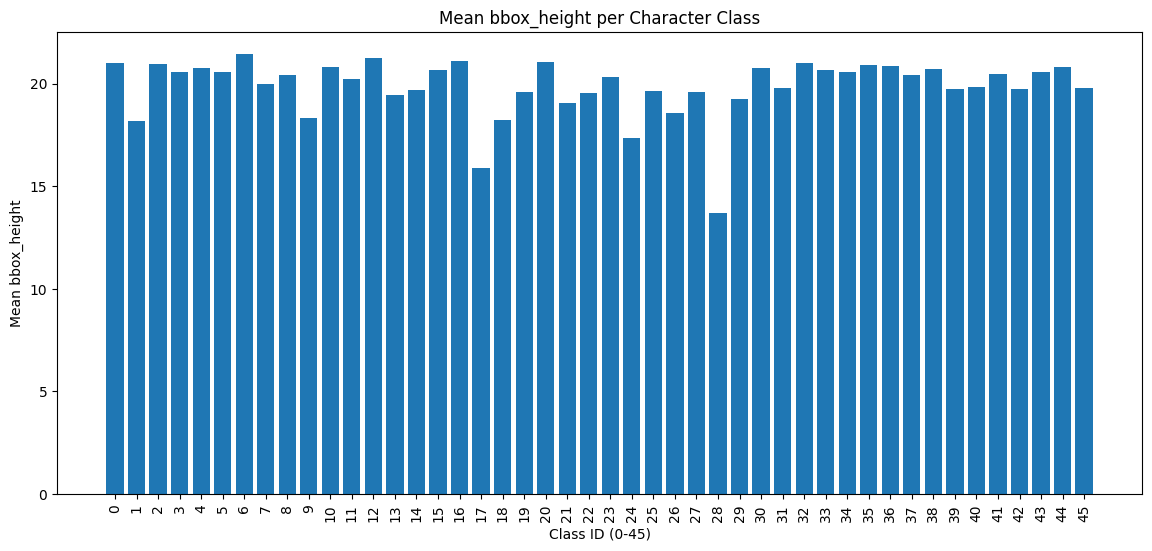

In [13]:

feature_to_plot = "bbox_height"

mean_per_class = df.groupby("label")[feature_to_plot].mean()

plt.figure(figsize = (14, 6))
plt.bar(range(len(mean_per_class)), mean_per_class)
plt.title(f"Mean {feature_to_plot} per Character Class", fontsize = 12)
plt.xlabel("Class ID (0-45)")
plt.ylabel(f"Mean {feature_to_plot}")
plt.xticks(range(46), rotation = 90)
plt.show()

In [14]:
def load_processed_image(path, target_size = (28, 28)):
    img = imread(path)
    if img.ndim == 3:
        img = rgb2gray(img)
    img = resize(img, target_size, anti_aliasing = True).astype(np.float32)
    return img

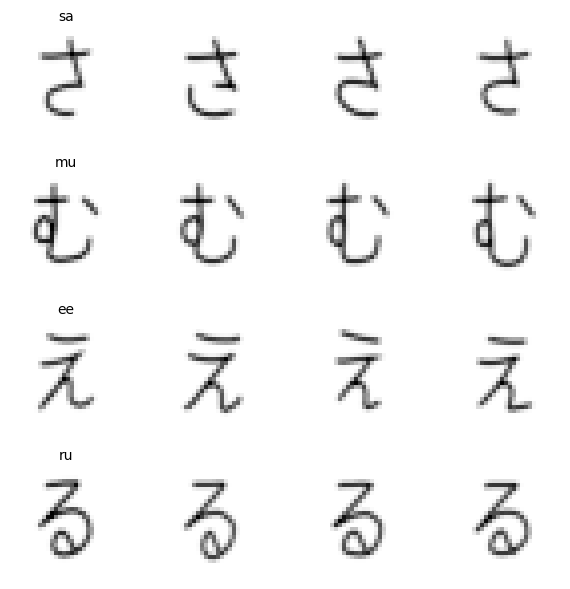

In [15]:
paths_by_class = {}
for p in image_paths:
    if p.parent.name not in paths_by_class:
        paths_by_class[p.parent.name] = []
    paths_by_class[p.parent.name].append(p)

classes_to_show = ["sa", "mu", "ee", "ru"]

fig, axes = plt.subplots(len(classes_to_show), 4, figsize=(6, 6))

for row, cls in enumerate(classes_to_show):
    sample_paths = random.sample(paths_by_class[cls], 4)
    for col, img_path in enumerate(sample_paths):
        ax = axes[row, col]
        img28 = load_processed_image(img_path)
        ax.imshow(img28, cmap="gray")
        ax.axis("off")
        if col == 0:
            ax.set_title(f"{cls}", fontsize=10)

plt.tight_layout()
plt.show()

## Splitting the dataset

I will split the dataset into:
- 70% training data
- 15% validation data (for hyperparameter tuning)
- 15% test data (for final evaluation)

In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, 
    y, 
    test_size = 0.30, 
    random_state = 42, 
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp, 
    test_size = 0.50, 
    random_state = 42, 
    stratify = y_temp
)

## Feature Scaling

In this section, I scale my data as part of preprocessing. I fit the scaler only on the training set, then apply the same scaling
parameters to the validation set and test set.

In [17]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Dataset Shape Verification

Before training any models, I verify that the feature matrices and label arrays have the correct shapes after splitting and scaling. Each feature vector should have 22 features.

In [18]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)

print("X_val_scaled shape:", X_val_scaled.shape)
print("y_val shape:", y_val.shape)

print("X_test_scaled shape:", X_test_scaled.shape)
print("y_test shape:", y_test.shape)

X_train_scaled shape: (3220, 11)
y_train shape: (3220,)
X_val_scaled shape: (690, 11)
y_val shape: (690,)
X_test_scaled shape: (690, 11)
y_test shape: (690,)


## LOGISTIC REGRESSION
### No Feature Transformation

In this section, I train a baseline multinomial Logistic Regression model.

In [19]:
logreg_results = []

In [20]:
def plot_logreg_metric_vs_C(df, metric, transformation_name):    
    plt.figure(figsize = (6, 4))

    subset = df[df["transformation"] == transformation_name].copy()
    subset = subset.sort_values(by = "C")
    
    Cs = subset["C"].values
    ys = subset[metric].values
    
    plt.plot(
        Cs,
        ys,
        marker = "o",
        label = transformation_name
    )
    
    plt.xscale("log")
    plt.xlabel("C (log scale)")
    plt.ylabel(metric.replace("val_", "").replace("_", " ").title())
    plt.title(f"Logistic Regression: {metric.replace('val_', '').upper()} vs C")
    plt.grid(True, alpha=0.3)
    plt.legend(title = "Transformation", fontsize=8)
    plt.tight_layout()
    plt.show()

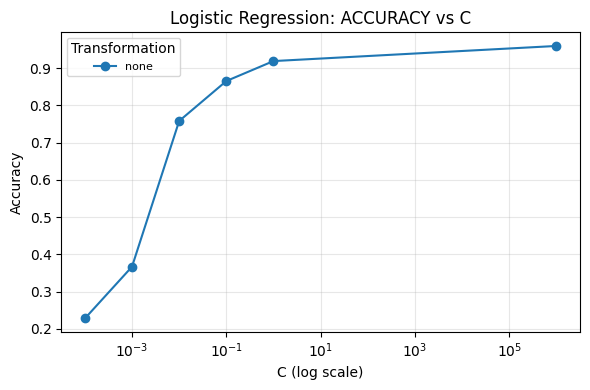

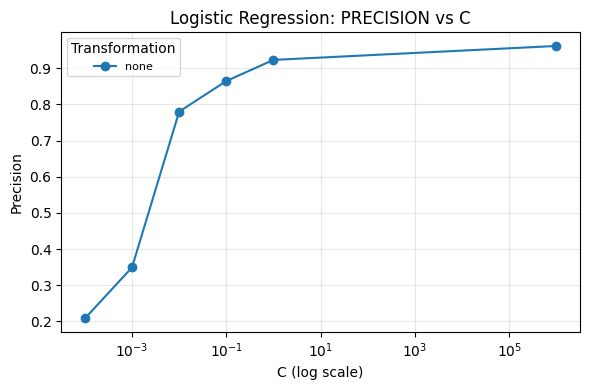

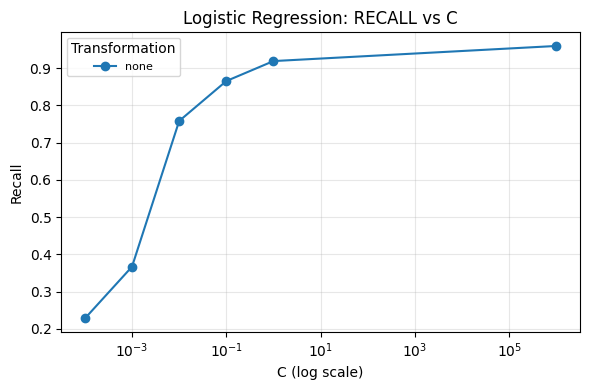

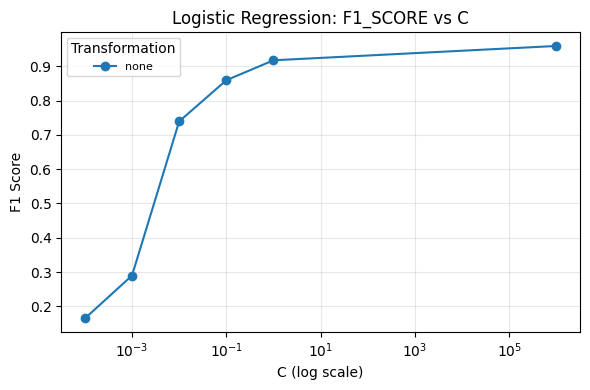

,transformation,C,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
0,none,1000000.0000,0.980124,0.959420,0.961789,0.959420,0.959037
1,none,1.0000,0.926708,0.918841,0.923226,0.918841,0.917269
2,none,0.1000,0.874534,0.865217,0.864772,0.865217,0.859132
3,none,0.0100,0.769565,0.757971,0.780226,0.757971,0.739163
4,none,0.0010,0.378261,0.366667,0.349217,0.366667,0.289839
5,none,0.0001,0.227640,0.227536,0.207941,0.227536,0.164634


In [21]:
C_values = [1e6, 1.0, 0.1, 0.01, 0.001, 0.0001]

for C in C_values:
    model = LogisticRegression(
        penalty = "l2",
        solver = "lbfgs",
        C = C,
        max_iter = 1000
    )

    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred   = model.predict(X_val_scaled)

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_prec = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_rec = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_f1 = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)

    logreg_results.append({
        "transformation": "none",
        "C": C,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc,
        "val_precision": val_prec,
        "val_recall": val_rec,
        "val_f1_score": val_f1
    })

logreg_df = pd.DataFrame(logreg_results)
plot_logreg_metric_vs_C(logreg_df, "val_accuracy", "none")
plot_logreg_metric_vs_C(logreg_df, "val_precision", "none")
plot_logreg_metric_vs_C(logreg_df, "val_recall", "none")
plot_logreg_metric_vs_C(logreg_df, "val_f1_score", "none")
logreg_df

### Feature Transformaion: Polynomial Degree-2

In this section, I train a Logistic Regression model with feature transformation of degree 2. 

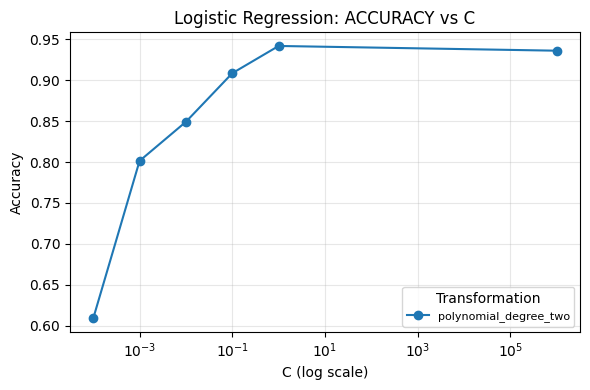

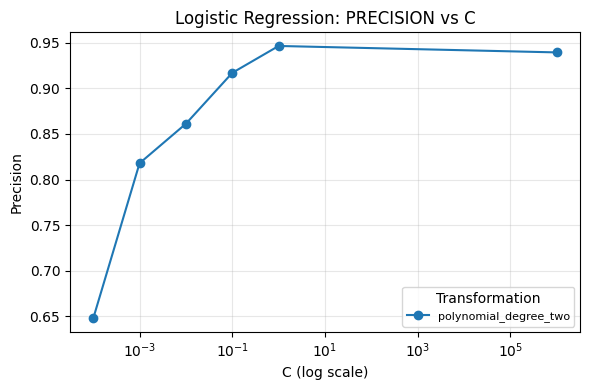

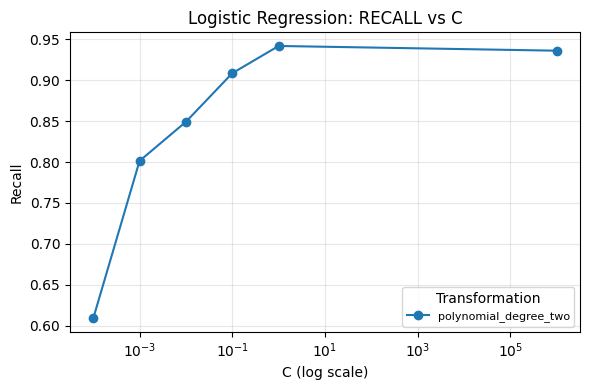

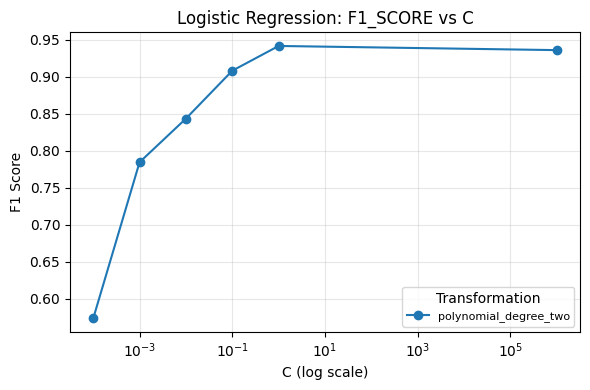

,transformation,C,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
6,polynomial_degree_two,1000000.0000,1.000000,0.936232,0.939354,0.936232,0.935721
7,polynomial_degree_two,1.0000,0.964596,0.942029,0.946421,0.942029,0.941348
8,polynomial_degree_two,0.1000,0.926708,0.908696,0.916955,0.908696,0.907937
9,polynomial_degree_two,0.0100,0.868323,0.849275,0.861191,0.849275,0.843286
10,polynomial_degree_two,0.0010,0.803727,0.801449,0.817881,0.801449,0.784377
11,polynomial_degree_two,0.0001,0.637578,0.608696,0.647703,0.608696,0.573405


In [22]:
poly_two = PolynomialFeatures(degree = 2, include_bias = False)

X_train_poly_two = poly_two.fit_transform(X_train_scaled)
X_val_poly_two = poly_two.transform(X_val_scaled)

for C in C_values:
    model = LogisticRegression(
        penalty = "l2",
        solver = "lbfgs",
        C = C,
        max_iter = 1000
    )

    model.fit(X_train_poly_two, y_train)
    y_train_pred = model.predict(X_train_poly_two)
    y_val_pred   = model.predict(X_val_poly_two)

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_prec = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_rec = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_f1 = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)

    logreg_results.append({
        "transformation": "polynomial_degree_two",
        "C": C,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc,
        "val_precision": val_prec,
        "val_recall": val_rec,
        "val_f1_score": val_f1
    })

logreg_df = pd.DataFrame(logreg_results)
polynomial_degree_two_df = logreg_df[logreg_df["transformation"] == "polynomial_degree_two"].copy()
plot_logreg_metric_vs_C(polynomial_degree_two_df, "val_accuracy", "polynomial_degree_two")
plot_logreg_metric_vs_C(polynomial_degree_two_df, "val_precision", "polynomial_degree_two")
plot_logreg_metric_vs_C(polynomial_degree_two_df, "val_recall", "polynomial_degree_two")
plot_logreg_metric_vs_C(polynomial_degree_two_df, "val_f1_score", "polynomial_degree_two")
polynomial_degree_two_df

### Feature Transformaion: Polynomial Degree-3

In this section, I train a Logistic Regression model with feature transformation of degree 3. 

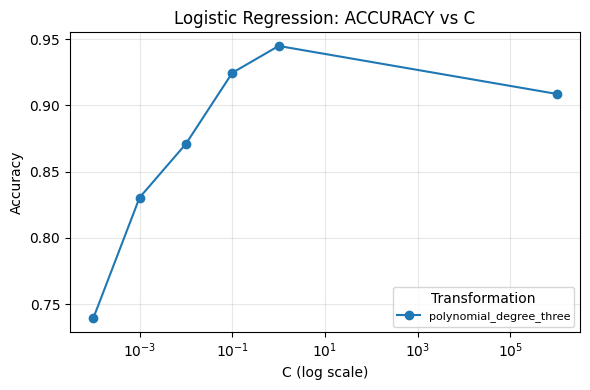

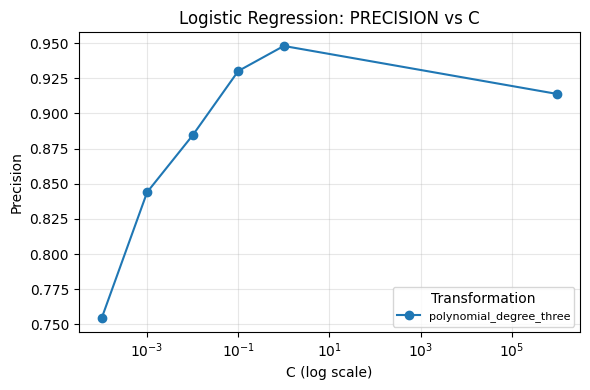

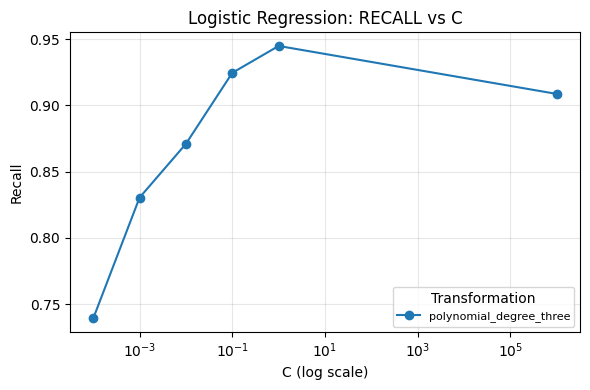

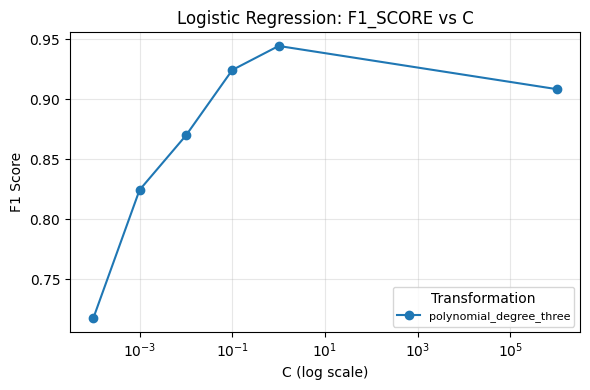

,transformation,C,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
12,polynomial_degree_three,1000000.0000,1.000000,0.908696,0.913862,0.908696,0.908354
13,polynomial_degree_three,1.0000,0.986335,0.944928,0.947993,0.944928,0.944343
14,polynomial_degree_three,0.1000,0.954658,0.924638,0.930174,0.924638,0.924325
15,polynomial_degree_three,0.0100,0.896273,0.871014,0.884496,0.871014,0.869773
16,polynomial_degree_three,0.0010,0.850621,0.830435,0.844011,0.830435,0.824409
17,polynomial_degree_three,0.0001,0.757764,0.739130,0.754218,0.739130,0.717317


In [23]:
poly_three = PolynomialFeatures(degree = 3, include_bias = False)

X_train_poly_three = poly_three.fit_transform(X_train_scaled)
X_val_poly_three = poly_three.transform(X_val_scaled)

for C in C_values:
    model = LogisticRegression(
        penalty = "l2",
        solver = "lbfgs",
        C = C,
        max_iter = 1000
    )

    model.fit(X_train_poly_three, y_train)
    y_train_pred = model.predict(X_train_poly_three)
    y_val_pred   = model.predict(X_val_poly_three)

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_prec = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_rec = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_f1 = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)

    logreg_results.append({
        "transformation": "polynomial_degree_three",
        "C": C,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc,
        "val_precision": val_prec,
        "val_recall": val_rec,
        "val_f1_score": val_f1
    })

logreg_df = pd.DataFrame(logreg_results)
polynomial_degree_three_df = logreg_df[logreg_df["transformation"] == "polynomial_degree_three"].copy()
plot_logreg_metric_vs_C(polynomial_degree_three_df, "val_accuracy", "polynomial_degree_three")
plot_logreg_metric_vs_C(polynomial_degree_three_df, "val_precision", "polynomial_degree_three")
plot_logreg_metric_vs_C(polynomial_degree_three_df, "val_recall", "polynomial_degree_three")
plot_logreg_metric_vs_C(polynomial_degree_three_df, "val_f1_score", "polynomial_degree_three")
polynomial_degree_three_df

### Feature Transformation: K-Means Cluster

In this section, I train a Logistic Regression with feature transformation of K-Means Clusters.

In [24]:
def kmeans_transform(X):
    return kmeans.transform(X)

/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


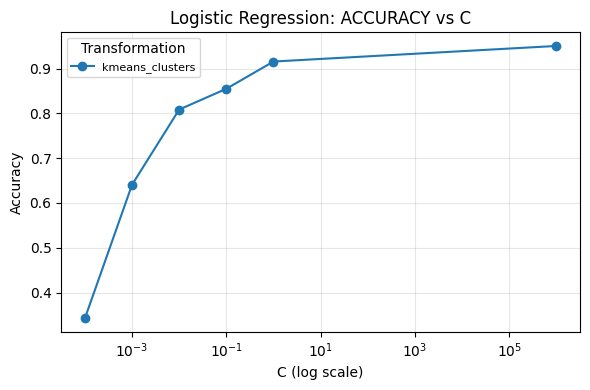

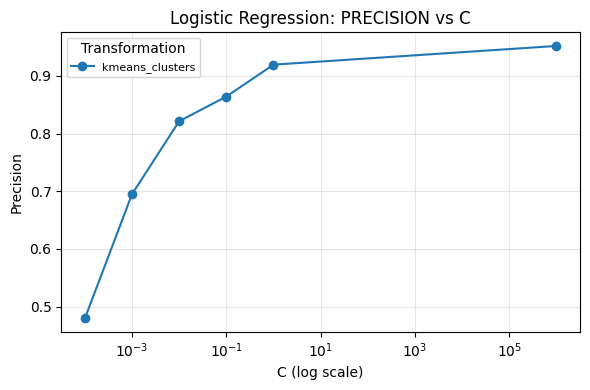

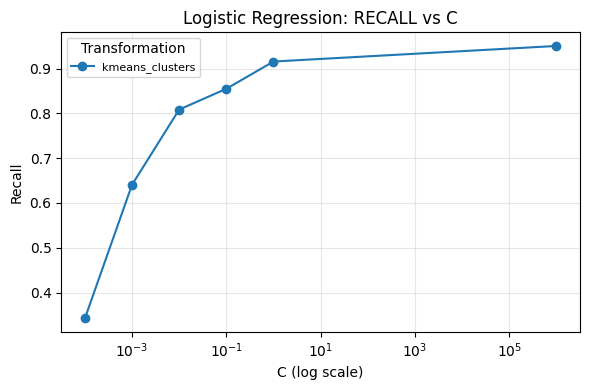

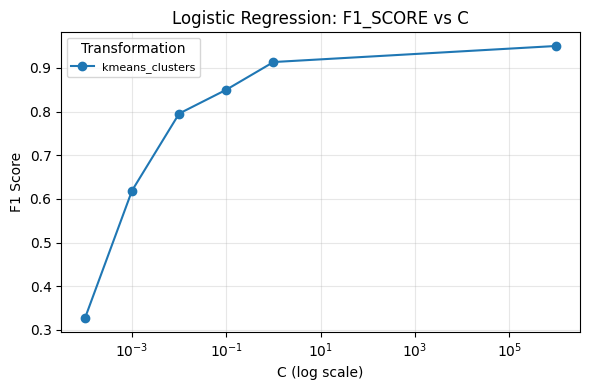

,transformation,C,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
18,kmeans_clusters,1000000.0000,0.988820,0.950725,0.952010,0.950725,0.950390
19,kmeans_clusters,1.0000,0.932609,0.915942,0.919580,0.915942,0.913552
20,kmeans_clusters,0.1000,0.874224,0.855072,0.864230,0.855072,0.850169
21,kmeans_clusters,0.0100,0.811491,0.808696,0.821515,0.808696,0.795519
22,kmeans_clusters,0.0010,0.662733,0.640580,0.694914,0.640580,0.618856
23,kmeans_clusters,0.0001,0.336025,0.342029,0.479296,0.342029,0.325889


In [25]:
kmeans = KMeans(n_clusters = 8, random_state = 42)
kmeans.fit(X_train_scaled)

X_train_km = np.hstack([X_train_scaled, kmeans_transform(X_train_scaled)])
X_val_km = np.hstack([X_val_scaled, kmeans_transform(X_val_scaled)])
X_test_km = np.hstack([X_test_scaled, kmeans_transform(X_test_scaled)])

for C in C_values:
    model = LogisticRegression(
        penalty = "l2",
        solver = "lbfgs",
        C = C,
        max_iter = 1000
    )

    model.fit(X_train_km, y_train)

    y_train_pred = model.predict(X_train_km)
    y_val_pred = model.predict(X_val_km)

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_prec = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_rec = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_f1 = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)

    logreg_results.append({
        "transformation": "kmeans_clusters",
        "C": C,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc,
        "val_precision": val_prec,
        "val_recall": val_rec,
        "val_f1_score": val_f1
    })

logreg_df = pd.DataFrame(logreg_results)
kmeans_clusters_df = logreg_df[logreg_df["transformation"] == "kmeans_clusters"].copy()
plot_logreg_metric_vs_C(kmeans_clusters_df, "val_accuracy", "kmeans_clusters")
plot_logreg_metric_vs_C(kmeans_clusters_df, "val_precision", "kmeans_clusters")
plot_logreg_metric_vs_C(kmeans_clusters_df, "val_recall", "kmeans_clusters")
plot_logreg_metric_vs_C(kmeans_clusters_df, "val_f1_score", "kmeans_clusters")
kmeans_clusters_df

## K-NEAREST NEIGHBORS
### No Transformation

In this section I train a baseline KNN model with varying k-neighbor values.

In [26]:
knn_results = []

In [27]:
def plot_knn_metric_vs_k(df, metric, transformation_name):
    subset = df[df["transformation"] == transformation_name].copy()
    subset = subset.sort_values(by="k")
    
    ks = subset["k"].values
    ys = subset[metric].values
    
    plt.figure(figsize=(6, 4))
    
    plt.plot(
        ks,
        ys,
        marker="o",
        label=transformation_name
    )
    
    plt.xlabel("k (number of neighbors)")
    plt.ylabel(metric.replace("val_", "").replace("_", " ").title())
    plt.title(f"KNN: {metric.replace('val_', '').upper()} vs k")
    
    plt.grid(True, alpha=0.3)
    plt.legend(title="Transformation", fontsize=8)
    plt.tight_layout()
    plt.show()


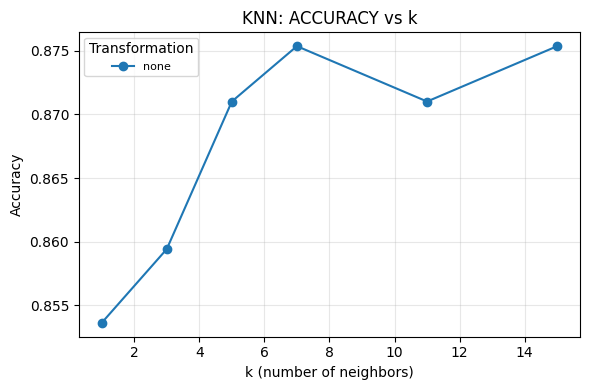

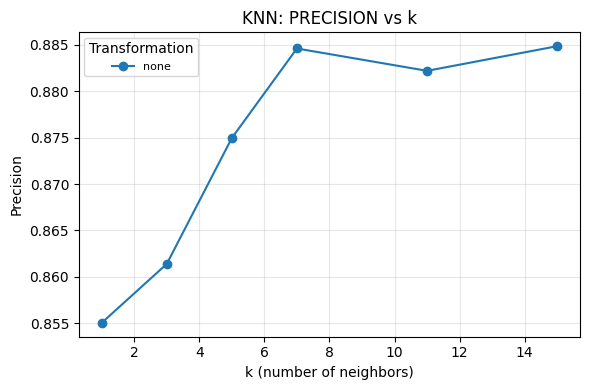

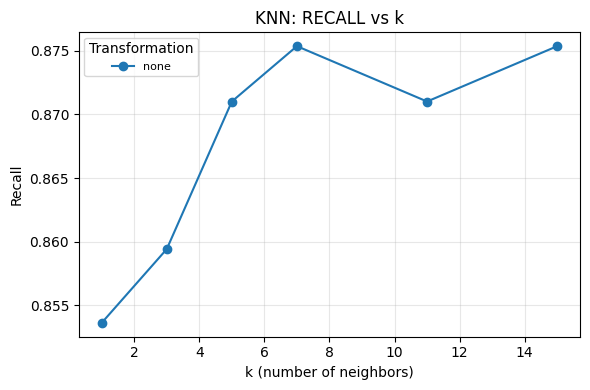

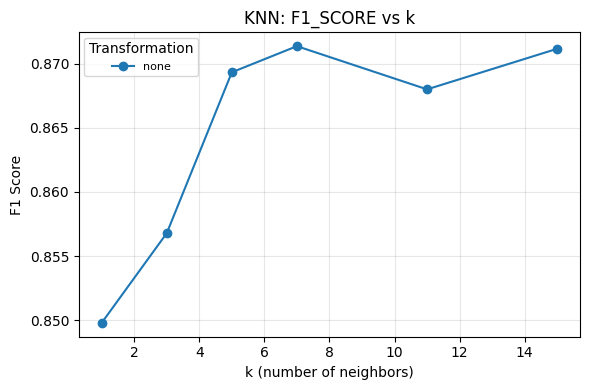

,transformation,k,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
0,none,1,1.000000,0.853623,0.855039,0.853623,0.849797
1,none,3,0.932919,0.859420,0.861388,0.859420,0.856789
2,none,5,0.924534,0.871014,0.874953,0.871014,0.869326
3,none,7,0.908075,0.875362,0.884599,0.875362,0.871362
4,none,11,0.896894,0.871014,0.882193,0.871014,0.867997
5,none,15,0.886335,0.875362,0.884850,0.875362,0.871159


In [28]:
k_values = [1, 3, 5, 7, 11, 15]

for k in k_values:
    model = KNeighborsClassifier(
        n_neighbors = k,
        weights = "uniform",
        metric = "euclidean"
    )

    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)
    

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_prec = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_rec = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_f1 = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    
    knn_results.append({
        "transformation": "none",
        "k": k,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc,
        "val_precision": val_prec,
        "val_recall": val_rec,
        "val_f1_score": val_f1,
    })

knn_df = pd.DataFrame(knn_results)
plot_knn_metric_vs_k(knn_df, "val_accuracy", "none")
plot_knn_metric_vs_k(knn_df, "val_precision", "none")
plot_knn_metric_vs_k(knn_df, "val_recall", "none")
plot_knn_metric_vs_k(knn_df, "val_f1_score", "none")
knn_df

### Feature Transformaion: Polynomial Degree-2

In this section, I train a KNN model with feature transformation of degree 2 and varying k-neighbor values.

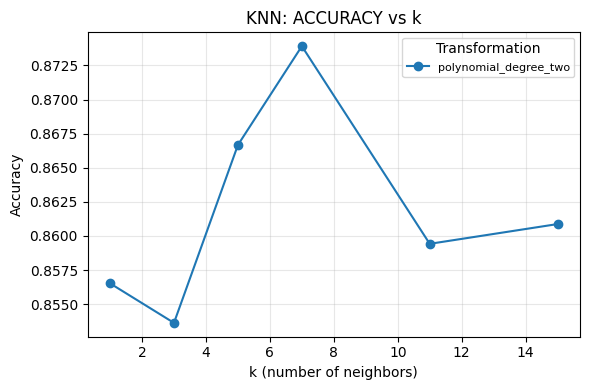

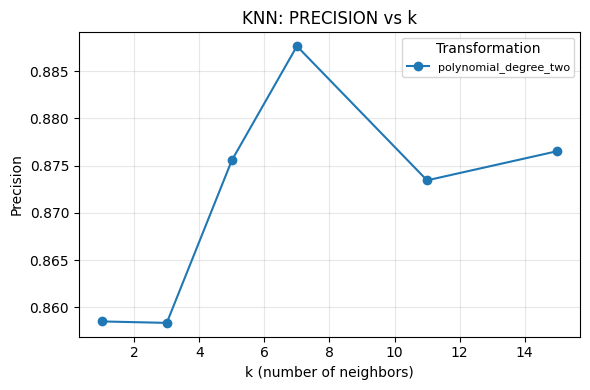

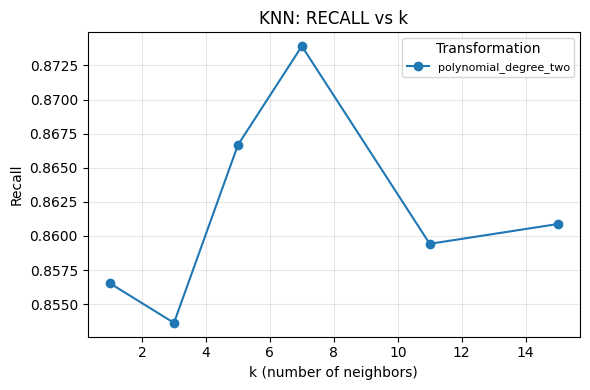

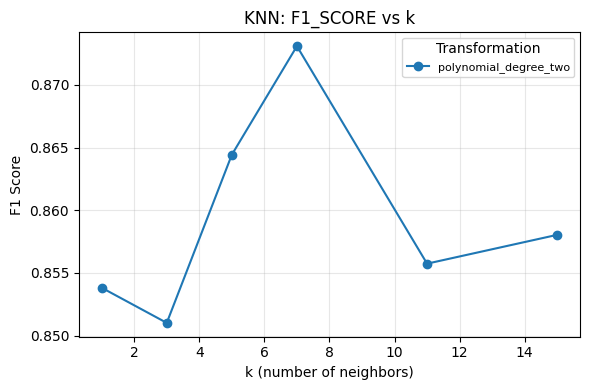

,transformation,k,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
6,polynomial_degree_two,1,1.000000,0.856522,0.858500,0.856522,0.853823
7,polynomial_degree_two,3,0.931056,0.853623,0.858346,0.853623,0.851021
8,polynomial_degree_two,5,0.916770,0.866667,0.875551,0.866667,0.864432
9,polynomial_degree_two,7,0.905280,0.873913,0.887635,0.873913,0.873090
10,polynomial_degree_two,11,0.891304,0.859420,0.873434,0.859420,0.855744
11,polynomial_degree_two,15,0.880745,0.860870,0.876520,0.860870,0.858044


In [29]:
for k in k_values:
    model = KNeighborsClassifier(
        n_neighbors = k,
        weights = "uniform",
        metric = "euclidean"
    )

    model.fit(X_train_poly_two, y_train)
    y_train_pred = model.predict(X_train_poly_two)
    y_val_pred = model.predict(X_val_poly_two)
    

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_prec = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_rec = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_f1 = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    
    knn_results.append({
        "transformation": "polynomial_degree_two",
        "k": k,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc,
        "val_precision": val_prec,
        "val_recall": val_rec,
        "val_f1_score": val_f1,
    })

knn_df = pd.DataFrame(knn_results)
knn_degree_two_df = knn_df[knn_df["transformation"] == "polynomial_degree_two"].copy()
plot_knn_metric_vs_k(knn_degree_two_df, "val_accuracy", "polynomial_degree_two")
plot_knn_metric_vs_k(knn_degree_two_df, "val_precision", "polynomial_degree_two")
plot_knn_metric_vs_k(knn_degree_two_df, "val_recall", "polynomial_degree_two")
plot_knn_metric_vs_k(knn_degree_two_df, "val_f1_score", "polynomial_degree_two")
knn_degree_two_df

### Feature Transformaion: Polynomial Degree-3

In this section, I train a KNN model with feature transformation of degree 3 and varying k-neighbor values.

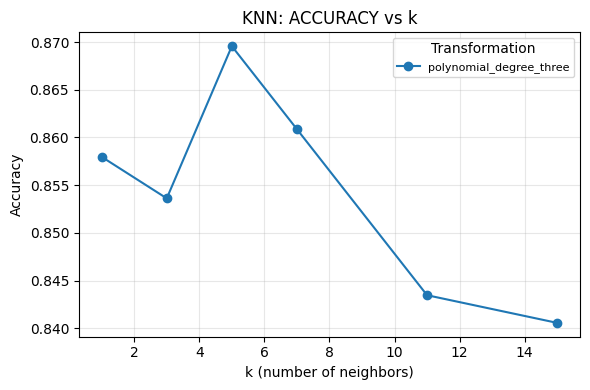

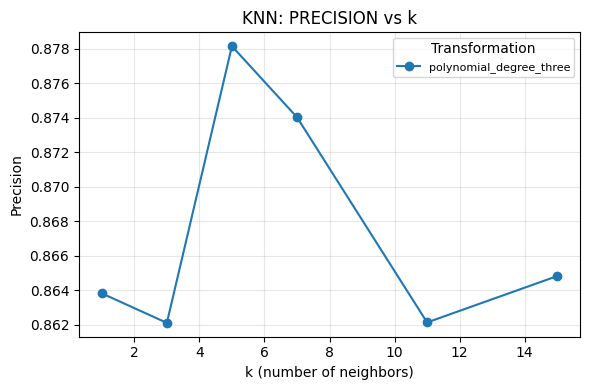

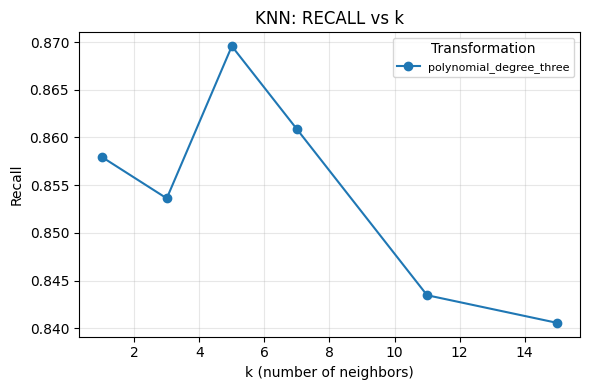

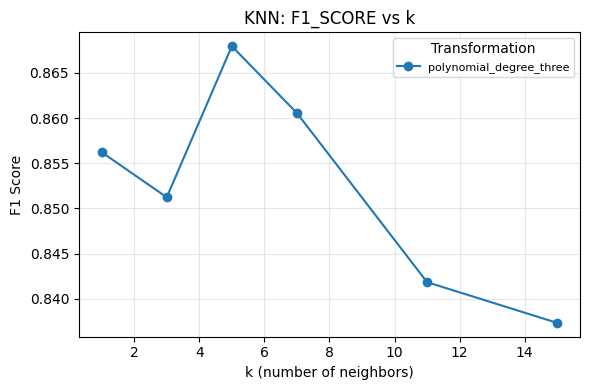

,transformation,k,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
12,polynomial_degree_three,1,1.000000,0.857971,0.863809,0.857971,0.856219
13,polynomial_degree_three,3,0.926398,0.853623,0.862095,0.853623,0.851239
14,polynomial_degree_three,5,0.909938,0.869565,0.878158,0.869565,0.867946
15,polynomial_degree_three,7,0.897516,0.860870,0.874033,0.860870,0.860551
16,polynomial_degree_three,11,0.881366,0.843478,0.862122,0.843478,0.841851
17,polynomial_degree_three,15,0.871739,0.840580,0.864813,0.840580,0.837349


In [30]:
for k in k_values:
    model = KNeighborsClassifier(
        n_neighbors = k,
        weights = "uniform",
        metric = "euclidean"
    )

    model.fit(X_train_poly_three, y_train)
    y_train_pred = model.predict(X_train_poly_three)
    y_val_pred = model.predict(X_val_poly_three)
    

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_prec = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_rec = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_f1 = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    
    knn_results.append({
        "transformation": "polynomial_degree_three",
        "k": k,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc,
        "val_precision": val_prec,
        "val_recall": val_rec,
        "val_f1_score": val_f1,
    })

knn_df = pd.DataFrame(knn_results)
knn_degree_three_df = knn_df[knn_df["transformation"] == "polynomial_degree_three"].copy()
plot_knn_metric_vs_k(knn_degree_three_df, "val_accuracy", "polynomial_degree_three")
plot_knn_metric_vs_k(knn_degree_three_df, "val_precision", "polynomial_degree_three")
plot_knn_metric_vs_k(knn_degree_three_df, "val_recall", "polynomial_degree_three")
plot_knn_metric_vs_k(knn_degree_three_df, "val_f1_score", "polynomial_degree_three")
knn_degree_three_df

### Feature Transformaion: K-Means Clusters

In this section, I train a KNN model with feature transformation of k-means clusters and varying k-neighbor values.

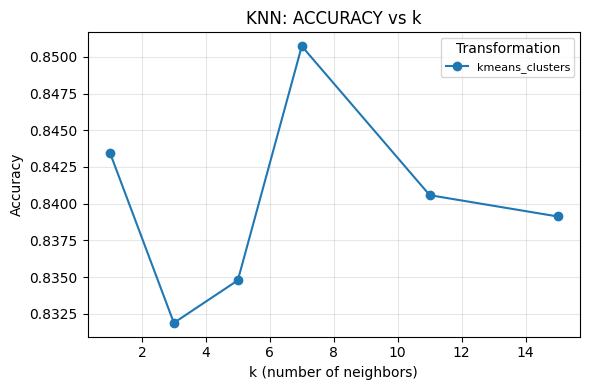

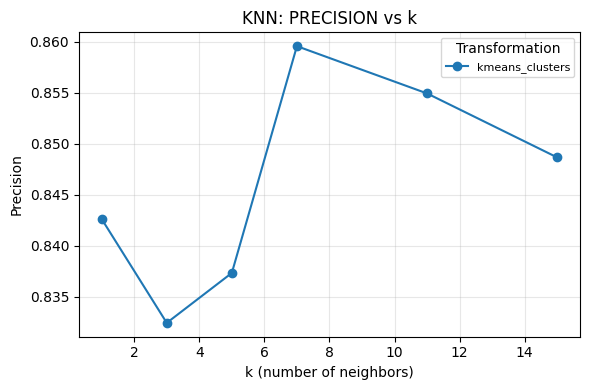

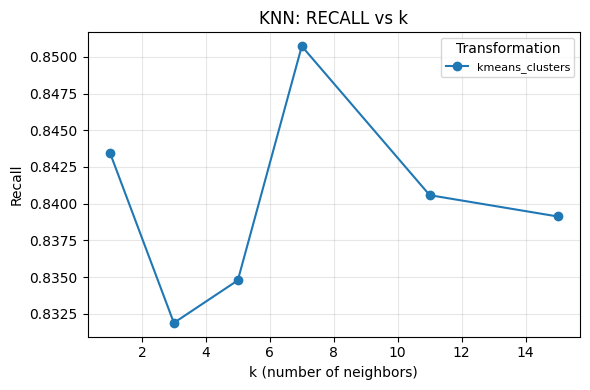

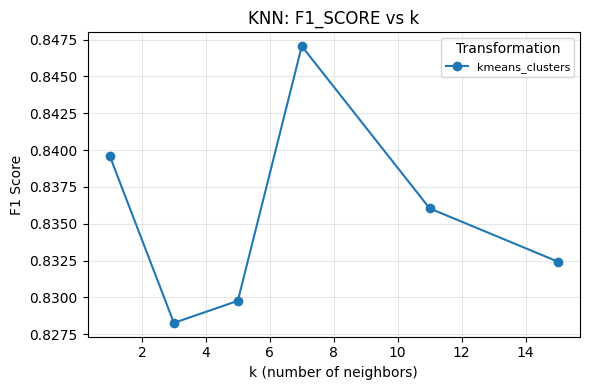

,transformation,k,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
18,kmeans_clusters,1,1.000000,0.843478,0.842618,0.843478,0.839580
19,kmeans_clusters,3,0.924534,0.831884,0.832436,0.831884,0.828275
20,kmeans_clusters,5,0.903416,0.834783,0.837330,0.834783,0.829771
21,kmeans_clusters,7,0.883230,0.850725,0.859559,0.850725,0.847055
22,kmeans_clusters,11,0.871739,0.840580,0.854927,0.840580,0.836043
23,kmeans_clusters,15,0.865217,0.839130,0.848653,0.839130,0.832440


In [31]:
for k in k_values:
    model = KNeighborsClassifier(
        n_neighbors = k,
        weights = "uniform",
        metric = "euclidean"
    )

    model.fit(X_train_km, y_train)
    y_train_pred = model.predict(X_train_km)
    y_val_pred = model.predict(X_val_km)
    

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_prec = precision_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_rec = recall_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    val_f1 = f1_score(y_val, y_val_pred, average = "macro", zero_division = 0)
    
    knn_results.append({
        "transformation": "kmeans_clusters",
        "k": k,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc,
        "val_precision": val_prec,
        "val_recall": val_rec,
        "val_f1_score": val_f1,
    })

knn_df = pd.DataFrame(knn_results)
knn_kmeans_clusters_df = knn_df[knn_df["transformation"] == "kmeans_clusters"].copy()
plot_knn_metric_vs_k(knn_kmeans_clusters_df, "val_accuracy", "kmeans_clusters")
plot_knn_metric_vs_k(knn_kmeans_clusters_df, "val_precision", "kmeans_clusters")
plot_knn_metric_vs_k(knn_kmeans_clusters_df, "val_recall", "kmeans_clusters")
plot_knn_metric_vs_k(knn_kmeans_clusters_df, "val_f1_score", "kmeans_clusters")
knn_kmeans_clusters_df

## NEURAL NETWORKS
### No Feature Transformation (64)

In this section, I train a baseline multinomial Neural Network model with activation functions: ReLU, Tanh, and Sigmoid. With each activation function, the alpha values: 0.000001, 0.0001, 0.001, 0.01, 0.1, and 1 are used.

In [32]:
def plot_nn_metric_vs_alphas(df, metric, transformation_name):
    subset = df[df["transformation"] == transformation_name].copy()
    activations = sorted(subset["activation"].unique())
    
    plt.figure(figsize = (6, 4))

    for act in activations:
        sub_act = subset[subset["activation"] == act].copy()
        sub_act = sub_act.sort_values(by = "alpha")

        alphas = sub_act["alpha"].values
        ys = sub_act[metric].values
        
        plt.plot(
            alphas,
            ys,
            marker = "o",
            label = act
        )

    plt.xscale("log")
    plt.xlabel("Alpha (L2 Regularization, log scale)")
    plt.ylabel(metric.replace("val_", "").replace("_", " ").title())
    plt.title(f"NN ({transformation_name}): {metric.replace('val_', '').upper()} vs Alpha")
    plt.grid(True, alpha = 0.3)
    plt.legend(title="Activation", fontsize = 8)
    plt.tight_layout()
    plt.show()

In [33]:
nn_results = []

/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the 

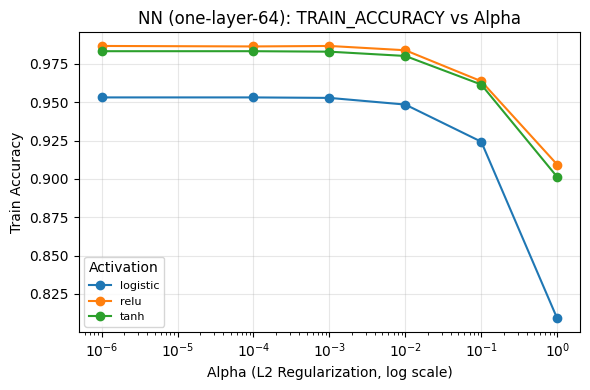

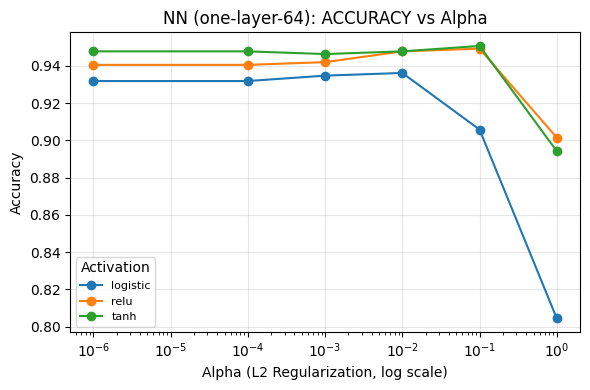

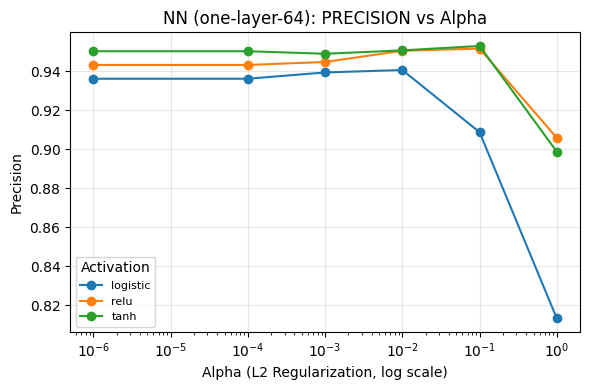

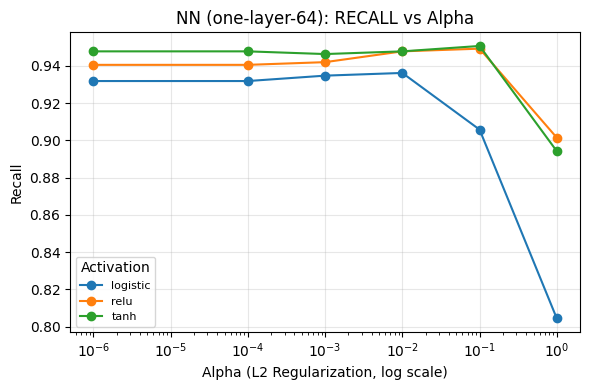

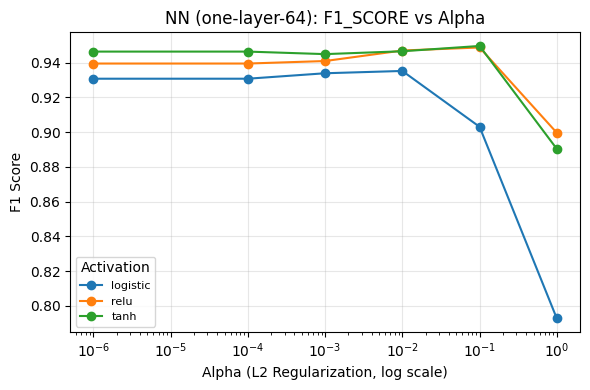

,transformation,activation,alpha,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
0,one-layer-64,relu,0.000001,0.986646,0.940580,0.943247,0.940580,0.939496
1,one-layer-64,relu,0.000100,0.986335,0.940580,0.943247,0.940580,0.939496
2,one-layer-64,relu,0.001000,0.986646,0.942029,0.944784,0.942029,0.940938
3,one-layer-64,relu,0.010000,0.983851,0.947826,0.950522,0.947826,0.946991
4,one-layer-64,relu,0.100000,0.963665,0.949275,0.951652,0.949275,0.948739
5,one-layer-64,relu,1.000000,0.909317,0.901449,0.905869,0.901449,0.899623
6,one-layer-64,tanh,0.000001,0.983230,0.947826,0.950292,0.947826,0.946372
7,one-layer-64,tanh,0.000100,0.983230,0.947826,0.950292,0.947826,0.946372
8,one-layer-64,tanh,0.001000,0.982919,0.946377,0.948989,0.946377,0.944915
9,one-layer-64,tanh,0.010000,0.980124,0.947826,0.950732,0.947826,0.946561


In [34]:
activations = ["relu", "tanh", "logistic"]
alpha_values = [1e-6, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]

for act in activations:
    for alpha in alpha_values:

        nn = MLPClassifier(
            hidden_layer_sizes = (64, ), 
            activation = act,
            alpha = alpha,
            max_iter = 500,
            random_state = 42
        )

        nn.fit(X_train_scaled, y_train)
        y_train_pred = nn.predict(X_train_scaled)
        y_val_pred   = nn.predict(X_val_scaled)

        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc   = accuracy_score(y_val, y_val_pred)
        val_prec  = precision_score(y_val, y_val_pred, average="macro", zero_division=0)
        val_rec   = recall_score(y_val, y_val_pred, average="macro", zero_division=0)
        val_f1    = f1_score(y_val, y_val_pred, average="macro", zero_division=0)

        nn_results.append({
            "transformation": "one-layer-64",
            "activation": act,
            "alpha": alpha,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc,
            "val_precision": val_prec,
            "val_recall": val_rec,
            "val_f1_score": val_f1,
        })

nn_df = pd.DataFrame(nn_results)
plot_nn_metric_vs_alphas(nn_df, "train_accuracy", "one-layer-64")
plot_nn_metric_vs_alphas(nn_df, "val_accuracy", "one-layer-64")
plot_nn_metric_vs_alphas(nn_df, "val_precision", "one-layer-64")
plot_nn_metric_vs_alphas(nn_df, "val_recall", "one-layer-64")
plot_nn_metric_vs_alphas(nn_df, "val_f1_score", "one-layer-64")
nn_df

### Neural Networks: Two Hidden Layers Neural Network (64, 32)

In this section, I train a two layer multinomial Neural Network model with activation functions: ReLU, Tanh, and Sigmoid. With each activation function, the alpha values: 0.000001, 0.0001, 0.001, 0.01, 0.1, and 1 are used.

/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the 

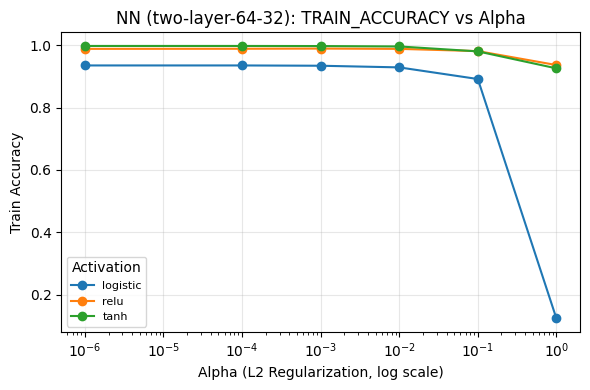

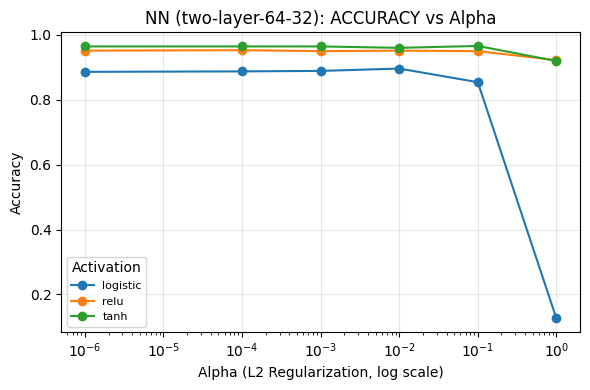

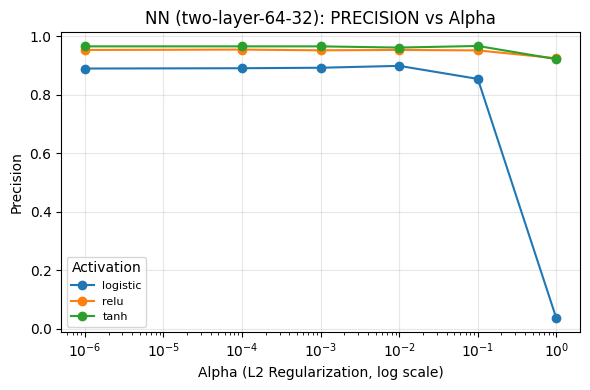

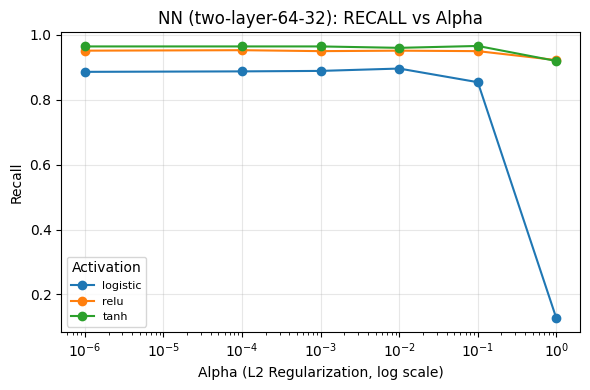

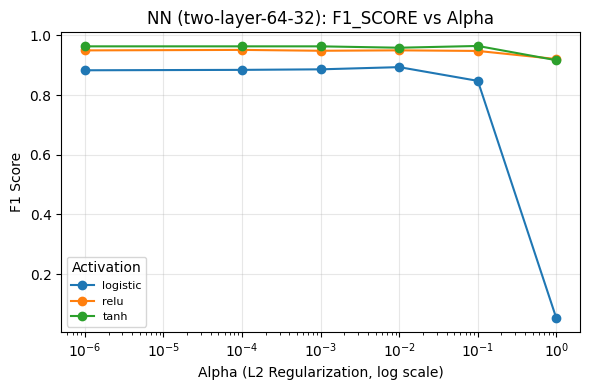

,transformation,activation,alpha,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
18,two-layer-64-32,relu,0.000001,0.987888,0.950725,0.952884,0.950725,0.949785
19,two-layer-64-32,relu,0.000100,0.988199,0.952174,0.954188,0.952174,0.951435
20,two-layer-64-32,relu,0.001000,0.988820,0.949275,0.951694,0.949275,0.948556
21,two-layer-64-32,relu,0.010000,0.987888,0.950725,0.952962,0.950725,0.949960
22,two-layer-64-32,relu,0.100000,0.980745,0.949275,0.951446,0.949275,0.947964
23,two-layer-64-32,relu,1.000000,0.936025,0.921739,0.924480,0.921739,0.920815
24,two-layer-64-32,tanh,0.000001,0.997205,0.963768,0.965171,0.963768,0.963362
25,two-layer-64-32,tanh,0.000100,0.997205,0.963768,0.965171,0.963768,0.963362
26,two-layer-64-32,tanh,0.001000,0.996894,0.963768,0.965171,0.963768,0.963362
27,two-layer-64-32,tanh,0.010000,0.995652,0.959420,0.961034,0.959420,0.958744


In [35]:
for act in activations:
    for alpha in alpha_values:

        nn = MLPClassifier(
            hidden_layer_sizes = (64, 32), 
            activation = act,
            alpha = alpha,
            max_iter = 500,
            random_state = 42
        )

        nn.fit(X_train_scaled, y_train)
        y_train_pred = nn.predict(X_train_scaled)
        y_val_pred   = nn.predict(X_val_scaled)

        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc   = accuracy_score(y_val, y_val_pred)
        val_prec  = precision_score(y_val, y_val_pred, average="macro", zero_division=0)
        val_rec   = recall_score(y_val, y_val_pred, average="macro", zero_division=0)
        val_f1    = f1_score(y_val, y_val_pred, average="macro", zero_division=0)

        nn_results.append({
            "transformation": "two-layer-64-32",
            "activation": act,
            "alpha": alpha,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc,
            "val_precision": val_prec,
            "val_recall": val_rec,
            "val_f1_score": val_f1,
        })

nn_df = pd.DataFrame(nn_results)
nn_two_layer_df = nn_df[nn_df["transformation"] == "two-layer-64-32"].copy()
plot_nn_metric_vs_alphas(nn_two_layer_df, "train_accuracy", "two-layer-64-32")
plot_nn_metric_vs_alphas(nn_two_layer_df, "val_accuracy", "two-layer-64-32")
plot_nn_metric_vs_alphas(nn_two_layer_df, "val_precision", "two-layer-64-32")
plot_nn_metric_vs_alphas(nn_two_layer_df, "val_recall", "two-layer-64-32")
plot_nn_metric_vs_alphas(nn_two_layer_df, "val_f1_score", "two-layer-64-32")
nn_two_layer_df

### Neural Networks: Three Hidden Layers Neural Network (64, 64, 32)

In this section, I train a three layer multinomial Neural Network model with activation functions: ReLU, Tanh, and Sigmoid. With each activation function, the alpha values: 0.000001, 0.0001, 0.001, 0.01, 0.1, and 1 are used.

/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the 

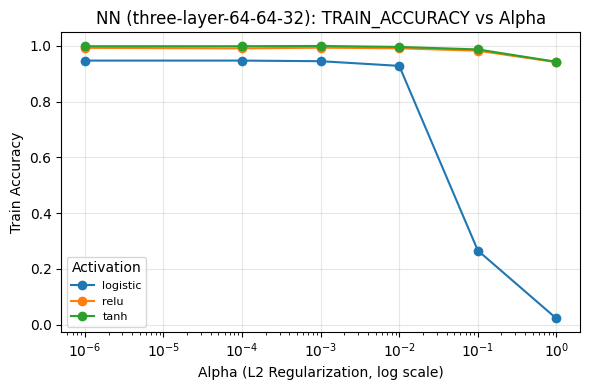

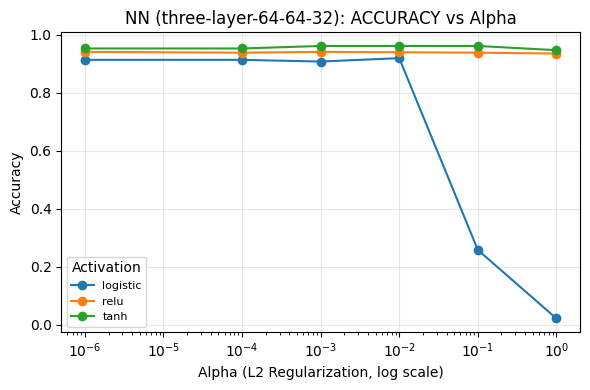

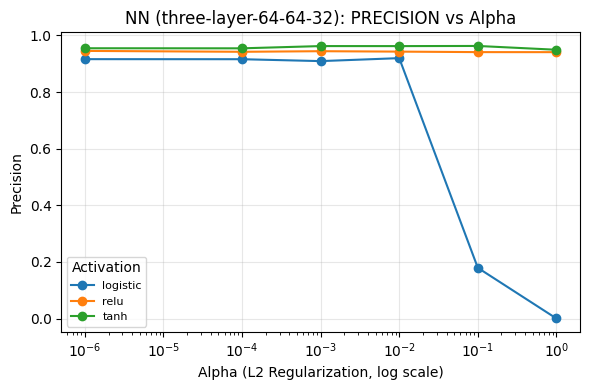

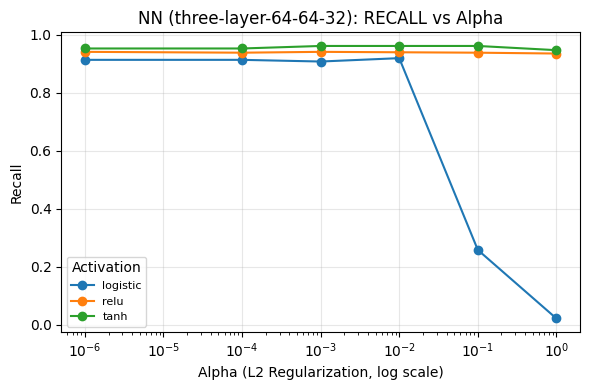

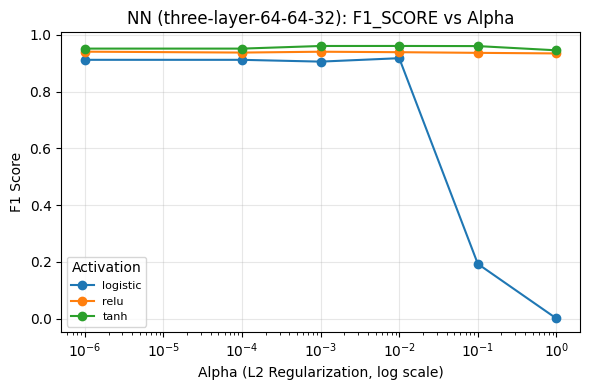

,transformation,activation,alpha,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
36,three-layer-64-64-32,relu,0.000001,0.992547,0.940580,0.945278,0.940580,0.940467
37,three-layer-64-64-32,relu,0.000100,0.990683,0.937681,0.942146,0.937681,0.937295
38,three-layer-64-64-32,relu,0.001000,0.993168,0.940580,0.944245,0.940580,0.940291
39,three-layer-64-64-32,relu,0.010000,0.990994,0.939130,0.942766,0.939130,0.938636
40,three-layer-64-64-32,relu,0.100000,0.982298,0.937681,0.941014,0.937681,0.936313
41,three-layer-64-64-32,relu,1.000000,0.941304,0.934783,0.940878,0.934783,0.934294
42,three-layer-64-64-32,tanh,0.000001,0.998447,0.952174,0.954650,0.952174,0.951269
43,three-layer-64-64-32,tanh,0.000100,0.998447,0.952174,0.954399,0.952174,0.951226
44,three-layer-64-64-32,tanh,0.001000,0.999379,0.960870,0.962336,0.960870,0.960466
45,three-layer-64-64-32,tanh,0.010000,0.995963,0.960870,0.962235,0.960870,0.960567


In [36]:
for act in activations:
    for alpha in alpha_values:

        nn = MLPClassifier(
            hidden_layer_sizes = (64, 64, 32), 
            activation = act,
            alpha = alpha,
            max_iter = 500,
            random_state = 42
        )

        nn.fit(X_train_scaled, y_train)
        y_train_pred = nn.predict(X_train_scaled)
        y_val_pred   = nn.predict(X_val_scaled)

        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc   = accuracy_score(y_val, y_val_pred)
        val_prec  = precision_score(y_val, y_val_pred, average="macro", zero_division=0)
        val_rec   = recall_score(y_val, y_val_pred, average="macro", zero_division=0)
        val_f1    = f1_score(y_val, y_val_pred, average="macro", zero_division=0)

        nn_results.append({
            "transformation": "three-layer-64-64-32",
            "activation": act,
            "alpha": alpha,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc,
            "val_precision": val_prec,
            "val_recall": val_rec,
            "val_f1_score": val_f1,
        })

nn_df = pd.DataFrame(nn_results)
nn_three_layer_df = nn_df[nn_df["transformation"] == "three-layer-64-64-32"].copy()
plot_nn_metric_vs_alphas(nn_three_layer_df, "train_accuracy", "three-layer-64-64-32")
plot_nn_metric_vs_alphas(nn_three_layer_df, "val_accuracy", "three-layer-64-64-32")
plot_nn_metric_vs_alphas(nn_three_layer_df, "val_precision", "three-layer-64-64-32")
plot_nn_metric_vs_alphas(nn_three_layer_df, "val_recall", "three-layer-64-64-32")
plot_nn_metric_vs_alphas(nn_three_layer_df, "val_f1_score", "three-layer-64-64-32")
nn_three_layer_df

### Neural Networks: Wider Two Hidden Layers Neural Network (128, 64)

In this section, I train a wider two layer multinomial Neural Network model with activation functions: ReLU, Tanh, and Sigmoid. With each activation function, the alpha values: 0.000001, 0.0001, 0.001, 0.01, 0.1, and 1 are used.

/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sam/Desktop/hiragana-ml-project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the 

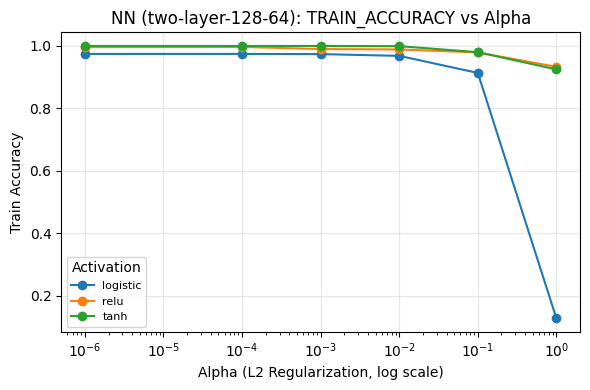

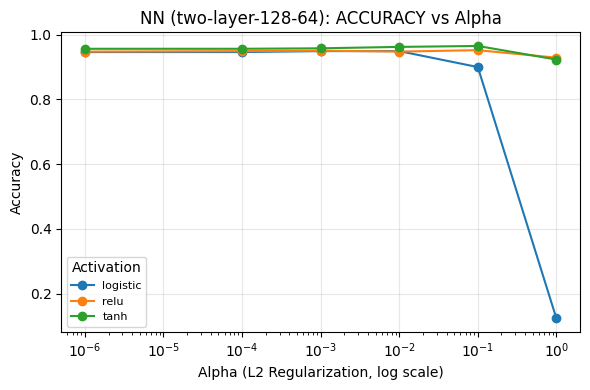

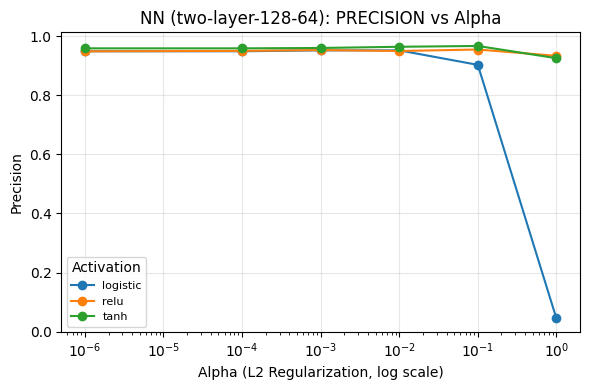

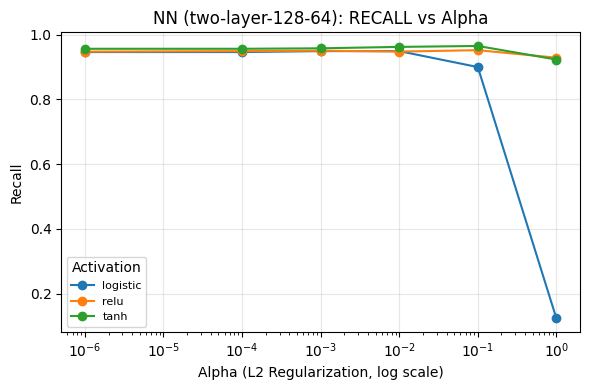

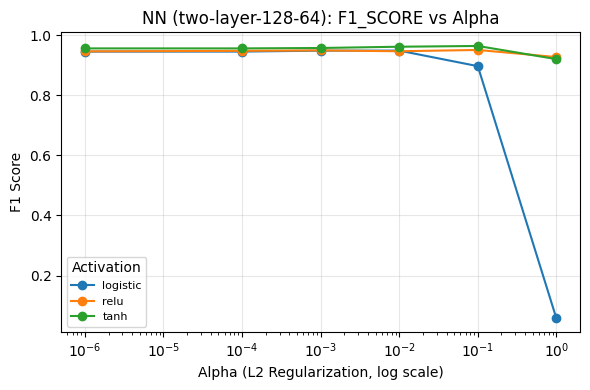

,transformation,activation,alpha,train_accuracy,val_accuracy,val_precision,val_recall,val_f1_score
54,two-layer-128-64,relu,0.000001,0.996273,0.947826,0.948889,0.947826,0.946451
55,two-layer-128-64,relu,0.000100,0.996894,0.949275,0.950369,0.949275,0.948260
56,two-layer-128-64,relu,0.001000,0.990062,0.950725,0.953065,0.950725,0.949644
57,two-layer-128-64,relu,0.010000,0.988820,0.947826,0.950010,0.947826,0.946893
58,two-layer-128-64,relu,0.100000,0.979193,0.952174,0.955016,0.952174,0.951197
59,two-layer-128-64,relu,1.000000,0.933230,0.928986,0.933577,0.928986,0.927559
60,two-layer-128-64,tanh,0.000001,1.000000,0.956522,0.958973,0.956522,0.956384
61,two-layer-128-64,tanh,0.000100,1.000000,0.956522,0.958973,0.956522,0.956384
62,two-layer-128-64,tanh,0.001000,1.000000,0.957971,0.960198,0.957971,0.957746
63,two-layer-128-64,tanh,0.010000,0.999379,0.962319,0.964295,0.962319,0.961967


In [37]:
for act in activations:
    for alpha in alpha_values:

        nn = MLPClassifier(
            hidden_layer_sizes = (128, 64), 
            activation = act,
            alpha = alpha,
            max_iter = 500,
            random_state = 42
        )

        nn.fit(X_train_scaled, y_train)
        y_train_pred = nn.predict(X_train_scaled)
        y_val_pred   = nn.predict(X_val_scaled)

        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc   = accuracy_score(y_val, y_val_pred)
        val_prec  = precision_score(y_val, y_val_pred, average="macro", zero_division=0)
        val_rec   = recall_score(y_val, y_val_pred, average="macro", zero_division=0)
        val_f1    = f1_score(y_val, y_val_pred, average="macro", zero_division=0)

        nn_results.append({
            "transformation": "two-layer-128-64",
            "activation": act,
            "alpha": alpha,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc,
            "val_precision": val_prec,
            "val_recall": val_rec,
            "val_f1_score": val_f1,
        })

nn_df = pd.DataFrame(nn_results)
nn_wide_two_layer_df = nn_df[nn_df["transformation"] == "two-layer-128-64"].copy()
plot_nn_metric_vs_alphas(nn_wide_two_layer_df, "train_accuracy", "two-layer-128-64")
plot_nn_metric_vs_alphas(nn_wide_two_layer_df, "val_accuracy", "two-layer-128-64")
plot_nn_metric_vs_alphas(nn_wide_two_layer_df, "val_precision", "two-layer-128-64")
plot_nn_metric_vs_alphas(nn_wide_two_layer_df, "val_recall", "two-layer-128-64")
plot_nn_metric_vs_alphas(nn_wide_two_layer_df, "val_f1_score", "two-layer-128-64")
nn_wide_two_layer_df

In [ ]:
"""
TODO:
- Refine features
- Fix overfitting
- Output more graphs: Confusion Matrix
- After completing and satisfied, use test set on model with best accuracy and hyperparameters
"""